In [278]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.autograd as autograd
import saliency.core as saliency

class ExplainerBase(object):

    def __init__(self, model_interface, data_interface):

        self.model_interface = model_interface
        self.data_interface = data_interface

    def generate_counterfactuals(self):

        raise NotImplementedError

    def opposing_class_constraint(self):
        
        raise NotImplementedError
        
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)  # Output has both mean and log variance
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        z_params = self.encoder(x)
        z_params = z_params.view(-1, 2, self.latent_dim)  # Reshape to (batch_size, 2, latent_dim)
        mu = z_params[:, 0, :]
        logvar = z_params[:, 1, :]
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar


        
class QUCE(ExplainerBase):
    def __init__(self, data_interface, model_interface, input_dim, latent_dim):
        super().__init__(data_interface, model_interface)
        self.vae = VAE(input_dim, latent_dim)
        self.vae_optimizer = optim.Adam(self.vae.parameters(), lr=0.1)
        self.latent_dim = latent_dim
    
    def compute_integrated_gradients_uncertainty(self, instances_list, num_steps=1000):
        integrated_gradients = torch.zeros_like(torch.tensor(instances_list[0]))  # Convert to PyTorch tensor

        start_instance_tensor = torch.tensor(instances_list[0], dtype=torch.float32, requires_grad=True)
        end_instance_tensor = torch.tensor(instances_list[1], dtype=torch.float32, requires_grad=True)

            # Linear interpolation between start and end instances
        path_interp = torch.linspace(0, 1, num_steps).view(-1, 1)
        interp_instances = (1 - path_interp) * start_instance_tensor + path_interp * end_instance_tensor

            # Compute model output at each interpolated point
        outputs = self.model_interface(interp_instances)

            # Sum the outputs to make it a scalar (assuming the model returns a tensor)
        outputs_sum = torch.sum(outputs)

            # Compute gradients at each interpolated point
        gradients = torch.autograd.grad(outputs_sum, interp_instances, retain_graph=True)[0]

            # Clip gradients to a reasonable range
            #gradients = torch.clamp(gradients, min=-1.0, max=1.0)
            # Integrate gradients along the path
        integrated_gradients = torch.sum(gradients, dim=0)/len(gradients)*(end_instance_tensor.detach().numpy() - start_instance_tensor.detach().numpy())
        return integrated_gradients
    
    
    def compute_integrated_gradients_interpolation(self, instances_list, num_steps=100):
        integrated_gradients = torch.zeros_like(torch.tensor(instances_list[0]))  # Convert to PyTorch tensor

        for i in range(len(instances_list) - 1):
            start_instance_tensor = torch.tensor(instances_list[i], dtype=torch.float32, requires_grad=True)
            end_instance_tensor = torch.tensor(instances_list[i + 1], dtype=torch.float32, requires_grad=True)

            # Linear interpolation between start and end instances
            path_interp = torch.linspace(0, 1, num_steps).view(-1, 1)
            interp_instances = (1 - path_interp) * start_instance_tensor + path_interp * end_instance_tensor

            # Compute model output at each interpolated point
            outputs = self.model_interface(interp_instances)

            # Sum the outputs to make it a scalar (assuming the model returns a tensor)
            outputs_sum = torch.sum(outputs)

            # Compute gradients at each interpolated point
            gradients = torch.autograd.grad(outputs_sum, interp_instances, retain_graph=True)[0]

            # Clip gradients to a reasonable range
            #gradients = torch.clamp(gradients, min=-1.0, max=1.0)
            # Integrate gradients along the path
            integrated_gradients += torch.sum(gradients, dim=0)/len(gradients)*(end_instance_tensor - start_instance_tensor)

        return integrated_gradients
    
    def compute_blur_integrated_gradients(self, instances_list, num_steps=100, blur_sigma=0.15):
        integrated_gradients = torch.zeros_like(torch.tensor(instances_list[0]))  # Convert to PyTorch tensor

        for i in range(len(instances_list) - 1):
            start_instance_tensor = torch.tensor(instances_list[i], dtype=torch.float32, requires_grad=True)
            end_instance_tensor = torch.tensor(instances_list[i + 1], dtype=torch.float32, requires_grad=True)

            # Linear interpolation between start and end instances
            path_interp = torch.linspace(0, 1, num_steps).view(-1, 1)
            interp_instances = (1 - path_interp) * start_instance_tensor + path_interp * end_instance_tensor

            # Compute model output at each interpolated point
            outputs = self.model_interface(interp_instances)

            # Sum the outputs to make it a scalar (assuming the model returns a tensor)
            outputs_sum = torch.sum(outputs)

            # Compute gradients at each interpolated point
            gradients = torch.autograd.grad(outputs_sum, interp_instances, retain_graph=True)[0]

            # Apply blur to gradients
            blurred_gradients = self.apply_blur(gradients, sigma=blur_sigma)

            # Integrate blurred gradients along the path
            integrated_gradients += torch.sum(blurred_gradients, dim=0) / len(blurred_gradients) * (
                    end_instance_tensor - start_instance_tensor)

        return integrated_gradients
    
    def apply_blur(gradients, sigma=0.15):
        # Apply blur to gradients
        blurred_gradients = torch.nn.functional.gaussian_blur(gradients, kernel_size=1, sigma=sigma)

        return blurred_gradients
    def generate_counterfactuals(self, query_instance, feature_mask=None ,time_constant_index=None, time_constant_diff=None, ts_dist_weight=0.5, reconstruction_weight=1, proba_weight=1, optimizer=None, target_prob_threshold=None, lr=0.01, max_iter=1000):
        query_instance = torch.FloatTensor(query_instance)
        num_features = len(query_instance)
        cf_initialize = query_instance.clone().detach()  # Start with the query instance
        cf_instances_list = []
        integrated_gradients = torch.zeros_like(cf_initialize)
        
        if feature_mask is None:
            feature_mask = torch.ones(num_features)
        else:
            feature_mask = torch.FloatTensor(feature_mask)

        if optimizer == "adam":
            optimizer = torch.optim.Adam([cf_initialize], lr, betas=(0.9, 0.999))  # Adjust beta1 and beta2 as needed
        else:
            optimizer = torch.optim.SGD([cf_initialize], lr, momentum=0.9)  # Adjust the momentum parameter as needed
        
        if target_prob_threshold == None:
            if self.model_interface(query_instance) >= 0.5: 
                target_prob_threshold = 0.05  # Set the desired threshold
            else:
                target_prob_threshold = 0.95
         
        target_class_prob = torch.FloatTensor([target_prob_threshold])

        self.vae.eval()

        for i in range(max_iter):
            cf_initialize.requires_grad = True
            optimizer.zero_grad()
            cf_prob = self.model_interface(cf_initialize)
    
    # Pass cf_initialize through the VAE to get reconstructed_x, mu, and logvar
            reconstructed_x, mu, logvar = self.vae(cf_initialize)
            
    # Calculate the loss
            vae_reconstruction_loss = self.vae_loss(query_instance, reconstructed_x, mu, logvar)
            loss = self.opposing_class_constraint(cf_prob, target_class_prob, query_instance
                                                  , ts_dist_weight, proba_weight, cf_initialize) + reconstruction_weight*vae_reconstruction_loss
            loss.backward()
            
            optimizer.step()
            cf_instances_list.append(cf_initialize.clone().detach().numpy())
            # Convert cf_instances_list to PyTorch tensor
        # Compute the absolute difference vector
        diff_vector = reconstructed_x

    # Run integrated gradients for perturbed_plus
        perturbed_plus = cf_initialize + torch.abs(diff_vector)
        explanation_plus = self.compute_integrated_gradients_uncertainty([cf_initialize, perturbed_plus])

    # Run integrated gradients for perturbed_minus
        perturbed_minus = cf_initialize - torch.abs(diff_vector)
        explanation_minus = self.compute_integrated_gradients_uncertainty([cf_initialize, perturbed_minus])

        integrated_gradients = self.compute_integrated_gradients_interpolation(cf_instances_list)
        return cf_initialize, integrated_gradients, explanation_plus, explanation_minus, cf_instances_list
    
    
    def exepcted_attribution(self, query_instance, p=1, **kwargs):
        """
        Perform iterative counterfactual generation and calculate the mean feature attribution.

        Parameters:
        - query_instance: The input instance for which counterfactuals are generated.
        - p: The number of iterations.
        - **kwargs: Additional arguments to pass to the generate_counterfactuals method.

        Returns:
        - mean_attributions: The mean feature attributions over p iterations.
        """
        attributions_sum = torch.zeros_like(torch.tensor(query_instance), dtype=torch.float32)

        for _ in range(p):
            _, attributions, _, _, _ = self.generate_counterfactuals(query_instance, **kwargs)
            attributions_sum += attributions

        mean_attributions = attributions_sum / p

        return mean_attributions
    
    def plot_explanations(self, integrated_gradients, explanation_plus, explanation_minus, feature_names=None):
        num_features = len(integrated_gradients)
        feature_indices = np.arange(num_features)

    # Plot main integrated gradients
        plt.bar(feature_indices, integrated_gradients.detach().numpy(), label='Integrated Path Attribution', color='grey', alpha=1)
        center_positions = feature_indices + integrated_gradients.detach().numpy()
    # Plot uncertainty bars
        plt.bar(
            center_positions,
            explanation_plus.detach().numpy(),
            bottom=integrated_gradients.detach().numpy(),
            color='blue',
            label='Uncertainty (+ε)',
            alpha=1
        )
        plt.bar(
            center_positions,
            explanation_minus.detach().numpy(),
            bottom=integrated_gradients.detach().numpy(),
            color='red',
            label='Uncertainty (-ε)',
            alpha=1
        )
        plt.xticks(ticks=feature_indices, labels=feature_names, rotation='vertical')
        
        plt.legend()
        plt.xlabel('Feature Index')
        plt.ylabel('Attribution Value')
        plt.title('Path-Based Gradients with Uncertainty (ε)')
        plt.show()

    
    def train_vae(self, query_instance, num_epochs):
        self.vae.train()
        for epoch in range(num_epochs):
            instance = torch.FloatTensor(query_instance)
            reconstructed_x, mu, logvar = self.vae(instance)
            loss = self.vae_loss(instance, reconstructed_x, mu, logvar)
            self.vae_optimizer.zero_grad()
            loss.backward()
            self.vae_optimizer.step()

    def vae_loss(self, x, reconstructed_x, mu, logvar):
        # Calculate the VAE loss (reconstruction loss + KL divergence)
        reconstruction_loss = nn.MSELoss()(reconstructed_x, x)  # Change the loss function for non-binary data
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return reconstruction_loss + kl_divergence
    
    def reconstruction_loss(self, x, reconstructed_x):
        # Calculate the VAE loss (reconstruction loss + KL divergence)
        reconstruction_loss = nn.MSELoss()(reconstructed_x, x)  # Change the loss function for non-binary data
        #kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return reconstruction_loss 

    
    def opposing_class_constraint(self, cf_prob, target_class_prob, query_instance, ts_dist_weight, proba_weight, cf_initialize):
    # Calculate a loss to ensure that the generated instance belongs to the opposing class and; 
    # the distance between query instance and the counterfactual is minimal

        cf_prob = F.sigmoid(cf_prob)

        target_class_loss = F.mse_loss(cf_prob, target_class_prob)
   
        distances = np.sum(np.linalg.norm(query_instance.detach().numpy() - cf_initialize.detach().numpy(), axis=1))

        # Define the distance decay rate - latter points in time have a greater weighting
        #alpha = 0.1 + 0.1 * np.arange(len(query_instances.detach().numpy()))

        # Apply the exponential kernel to assign weights
        #weights = np.exp(-alpha * distances)

        # Normalize the weights (optional)
        #normalized_weights = weights / np.sum(weights)

        # Compute the weighted result
        #weighted_distance_list = np.dot(normalized_weights, query_instances.detach().numpy())
        #weighted_distance = np.sum(weighted_distance_list)
        return proba_weight*target_class_loss + ts_dist_weight*distances
        
        

In [279]:
def integrated_gradients_attribution(model, target, num_steps=1000):
    integrated_gradients = torch.zeros_like(torch.tensor(target))  # Convert to PyTorch tensor
    baseline = torch.zeros_like(torch.tensor(target))
    start_instance_tensor = torch.tensor(baseline, dtype=torch.float32, requires_grad=True)
    end_instance_tensor = torch.tensor(target, dtype=torch.float32, requires_grad=True)

            # Linear interpolation between start and end instances
    path_interp = torch.linspace(0, 1, num_steps).view(-1, 1)
    interp_instances = (1 - path_interp) * start_instance_tensor + path_interp * end_instance_tensor
               # Compute model output at each interpolated point
    outputs = model(interp_instances)

            # Sum the outputs to make it a scalar (assuming the model returns a tensor)
    outputs_sum = torch.sum(outputs)

            # Compute gradients at each interpolated point
    gradients = torch.autograd.grad(outputs_sum, interp_instances, retain_graph=True)[0]

            # Clip gradients to a reasonable range
            #gradients = torch.clamp(gradients, min=-1.0, max=1.0)
            # Integrate gradients along the path
    integrated_gradients += torch.sum(gradients, dim=0)
    
    integrated_gradients = integrated_gradients/len(gradients)

    return integrated_gradients*(end_instance_tensor - start_instance_tensor)

In [280]:
def individual_agi_sigmoid(model, x, epsilon=0.01, max_steps=1000):
    model.eval()
    x.requires_grad = True

    agi_path = [x.clone().detach()]
    j = 0

    while torch.sigmoid(model(x)) >= 0.5 and j < max_steps:
        # Compute the gradient of the sigmoid output
        grad_sigmoid = torch.autograd.grad(torch.sigmoid(model(x)), x)[0]

        # Adversarial direction
        adv_direction = epsilon * torch.sign(grad_sigmoid)

        # Update AGI
        x = x - adv_direction
        new_x = x 

        # Append the current value of x to the path
        agi_path.append(x.clone().detach())

        j += 1

    return agi_path, new_x

In [281]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data['data']
y = data.target 

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.20, random_state=10)

In [282]:
ft_names = data.feature_names

In [283]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

train_features = train_features.astype(float)
test_features = test_features.astype(float)


In [338]:
torch.manual_seed(1)  # Set seed for reproducibility.
n_input, n_hidden, n_out, batch_size, learning_rate = 30, 60, 1, 100, 0.01

input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid()
                     )

loss_function = nn.BCELoss() # nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for epoch in range(5000):
    pred_y = model(input_tensor.float())
    loss = loss_function(torch.flatten(pred_y), label_tensor.to(torch.float32))
    losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    optimizer.step()
model = model.eval()  # Set the model to evaluation mode

In [340]:
generator = QUCE(model, input_tensor, input_dim = input_tensor.shape[1], latent_dim=15)

In [344]:
generated_instance = generator.generate_counterfactuals(query_instance = test_input_tensor[0:1], ts_dist_weight=0.7, reconstruction_weight=1, proba_weight=1, lr=0.1, optimizer='adam', target_prob_threshold=None)

C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:297: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  target_class_loss = F.mse_loss(cf_prob, target_class_prob)
C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  integrated_gradients = torch.zeros_like(torch.tensor(instances_list[0]))  # Convert to PyTorch tensor
C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start_instance_tensor = tor

In [347]:
model(test_input_tensor[0:1])

tensor([[2.0574e-24]], grad_fn=<SigmoidBackward0>)

In [346]:
model(generated_instance[0])

tensor([[1.]], grad_fn=<SigmoidBackward0>)

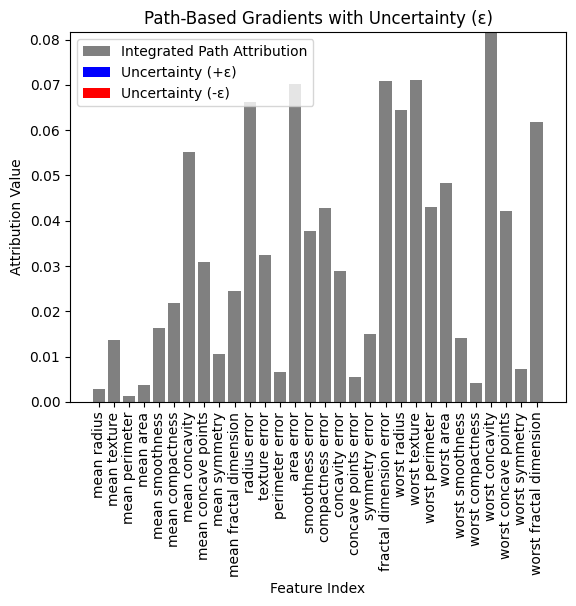

In [348]:
generator.plot_explanations(generated_instance[1][0], generated_instance[2][0], generated_instance[3][0], feature_names=ft_names)

In [288]:
#other methods below 

In [289]:
import dice_ml
from dice_ml import Dice

In [290]:
train_features2, test_features2, train_labels2, test_labels2 = train_test_split(X, y, 
                                                                                  shuffle=False, train_size=0.80)   

scaler = StandardScaler()

train_features2 = scaler.fit_transform(train_features2)
test_features2 = scaler.transform(test_features2)

In [291]:
data_for_dice = pd.DataFrame(data=train_features2, columns=ft_names)
data_for_dice_test = pd.DataFrame(data=test_features2, columns=ft_names)
# Add the "Malignancy" column to the DataFrame using train_labels2
data_for_dice['Malignancy'] = train_labels2
data_for_dice_test['Malignancy'] = test_labels2

In [292]:
train_features2 = pd.DataFrame(train_features2, columns=ft_names)

In [293]:
test_features2 = pd.DataFrame(test_features2, columns=ft_names)

In [303]:
d = dice_ml.Data(dataframe=data_for_dice.astype(float),
                 continuous_features=list(ft_names),
                 outcome_name='Malignancy')
dt = dice_ml.Data(dataframe=data_for_dice_test.astype(float),
                 continuous_features=list(ft_names),
                 outcome_name='Malignancy')
# Pre-trained ML model
m = dice_ml.Model(model=model, backend="PYT", model_type='classifier')

exp = dice_ml.Dice(d,m, method='random')
query_instance = data_for_dice.drop(columns="Malignancy")

exp_test = dice_ml.Dice(dt,m, method='random')
query_instance_test = data_for_dice_test.drop(columns="Malignancy")

In [304]:
def convert_tensors_to_values(df):
    """
    Convert PyTorch tensors in a DataFrame to numerical values.

    Args:
    - df: Pandas DataFrame with columns containing PyTorch tensors

    Returns:
    - df: Pandas DataFrame with tensors replaced by numerical values
    """
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x.item() if torch.is_tensor(x) else x)
    return df

In [305]:
gen = exp.generate_counterfactuals(query_instance[0:100], total_CFs=1, desired_class='opposite')

100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


In [306]:
gen_test = exp.generate_counterfactuals(query_instance_test[0:100], total_CFs=1, desired_class='opposite')

100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


## Counterfactual Uncertainty Measurements

### QUCE

### Train

In [355]:
num_instances = 100
sum_values = 0
vae_error = 0
for i in range(num_instances):
    # Assuming test_input_tensor[i:i+1] is your input tensor
    example_tensor_quce = input_tensor[i:i+1]
    
    # Generate counterfactual using the generator
    counterfactual_result = generator.generate_counterfactuals(
        query_instance=example_tensor_quce,
        ts_dist_weight=0.7,
        reconstruction_weight=1,
        proba_weight=1,
        lr=0.01,
        optimizer='adam',
        target_prob_threshold=None
    )[0][0]

    # Extract relevant information (adjust based on the structure of the result)
    reconstructed_tensor, mu, logvar = generator.vae(counterfactual_result)
    vae_error += generator.vae_loss(counterfactual_result, reconstructed_tensor, mu, logvar)
    # Sum the values
    sum_values += np.mean((np.abs(reconstructed_tensor.detach().numpy() - counterfactual_result.detach().numpy())))
    
average_values_QUCE = sum_values/num_instances
average_error_QUCE = vae_error/num_instances

C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:297: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  target_class_loss = F.mse_loss(cf_prob, target_class_prob)
C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  integrated_gradients = torch.zeros_like(torch.tensor(instances_list[0]))  # Convert to PyTorch tensor
C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start_instance_tensor = tor

In [356]:
average_values_QUCE

0.7333594852685928

In [357]:
average_error_QUCE

tensor(0.9296, grad_fn=<DivBackward0>)

### Test

In [400]:
num_instances = 100
sum_values = 0
vae_error = 0 
for i in range(num_instances):
    # Assuming test_input_tensor[i:i+1] is your input tensor
    example_tensor_quce = test_input_tensor[i:i+1]
    
    # Generate counterfactual using the generator
    counterfactual_result = generator.generate_counterfactuals(
        query_instance=example_tensor_quce,
        ts_dist_weight=0.7,
        reconstruction_weight=1,
        proba_weight=1,
        lr=0.01,
        optimizer='adam',
        target_prob_threshold=None
    )[0][0]

    # Extract relevant information (adjust based on the structure of the result)
    reconstructed_tensor, mu, logvar = generator.vae(counterfactual_result)
    vae_error += generator.vae_loss(counterfactual_result, reconstructed_tensor, mu, logvar)
    # Sum the values
    sum_values += np.mean((np.abs(reconstructed_tensor.detach().numpy() - counterfactual_result.detach().numpy())))
    
average_values_QUCE = sum_values/num_instances
average_error_QUCE = vae_error/num_instances

C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:297: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  target_class_loss = F.mse_loss(cf_prob, target_class_prob)
C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  integrated_gradients = torch.zeros_like(torch.tensor(instances_list[0]))  # Convert to PyTorch tensor
C:\Users\Jamie\AppData\Local\Temp\ipykernel_15112\826980763.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  start_instance_tensor = tor

In [401]:
average_values_QUCE

0.7647446596622467

In [402]:
average_error_QUCE

tensor(1.0755, grad_fn=<DivBackward0>)

### DiCE

### Train

In [385]:
num_instances = 100
sum_values = 0
vae_error = 0 
for i in range(num_instances):
    # Assuming gen.cf_examples_list[i] is your example
    example_tensor_dice = torch.tensor(gen.cf_examples_list[i].final_cfs_df.iloc[0][:-1], dtype=torch.float)
    reconstructed_tensor, mu, logvar = generator.vae(example_tensor_dice)
    vae_error += generator.vae_loss(example_tensor_dice, reconstructed_tensor, mu, logvar)

    # Sum the values
    sum_values += np.mean(np.abs(reconstructed_tensor.detach().numpy() - np.array(gen.cf_examples_list[i].final_cfs_df.iloc[0][:-1])))
    
# Average the values
average_values = sum_values / num_instances
average_error_DiCE = vae_error/num_instances


In [386]:
average_values

1.0369083190410773

In [387]:
average_error_DiCE

tensor(3.6266, grad_fn=<DivBackward0>)

### Test

In [388]:
num_instances = 100
sum_values = 0
vae_error = 0 
for i in range(num_instances):
    # Assuming gen.cf_examples_list[i] is your example
    example_tensor_dice = torch.tensor(gen_test.cf_examples_list[i].final_cfs_df.iloc[0][:-1], dtype=torch.float)
 
    reconstructed_tensor, mu, logvar = generator.vae(example_tensor_dice)
    vae_error += generator.vae_loss(example_tensor_dice, reconstructed_tensor, mu, logvar)

    # Sum the values
    sum_values += np.mean(np.abs(reconstructed_tensor.detach().numpy() - np.array(gen.cf_examples_list[i].final_cfs_df.iloc[0][:-1])))
    
# Average the values
average_values = sum_values / num_instances
average_error_DiCE = vae_error/num_instances

In [389]:
average_values

1.0390261217396501

In [390]:
average_error_DiCE

tensor(2.9992, grad_fn=<DivBackward0>)

### AGI

### Train

In [391]:
num_instances = 100
sum_values = 0
vae_error = 0 

for i in range(num_instances):
    example_tensor1 = individual_agi_sigmoid(model, input_tensor[i])[1]
    reconstructed_tensor, mu, logvar = generator.vae(example_tensor1)
    vae_error += generator.vae_loss(example_tensor1, reconstructed_tensor, mu, logvar)
    sum_values += np.mean(np.abs(reconstructed_tensor.detach().numpy() - example_tensor1.detach().numpy()))

# Average the values
average_values = sum_values / num_instances
average_error_AGI = vae_error/num_instances


C:\Users\Jamie\anaconda3\envs\temporal-project-env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.795204091668129

In [392]:
average_values

0.795204091668129

In [393]:
average_error_AGI

tensor(1.2210, grad_fn=<DivBackward0>)

### Test

In [397]:
num_instances = 100
sum_values = 0
vae_error = 0 
for i in range(num_instances):
    example_tensor1 = individual_agi_sigmoid(model, test_input_tensor[i])[1]
    reconstructed_tensor, mu, logvar = generator.vae(example_tensor1)
    vae_error += generator.vae_loss(example_tensor1, reconstructed_tensor, mu, logvar)
    sum_values += np.mean(np.abs(reconstructed_tensor.detach().numpy() - example_tensor1.detach().numpy()))

# Average the values
average_values = sum_values / num_instances
average_error_AGI = vae_error/num_instances


In [398]:
average_values

0.8021301743388176

In [399]:
average_error_AGI

tensor(1.4125, grad_fn=<DivBackward0>)

# Insertion Scores 

In [ ]:
def iterative_feature_addition_with_auc_ordered(model, input_tensor, attribution_tensor, top_k=1):
    model.eval()

    num_features = input_tensor.size(1)
    prob_values = []

    baseline_tensor = torch.zeros_like(input_tensor)

    # Get the indices of features in descending order of importance
    _, sorted_indices = torch.sort(attribution_tensor, descending=True)

    total_prob_change = 0.0  # Initialize the cumulative change in probabilities

    for i in range(top_k):
        # Add features in order of importance
        baseline_tensor[:, sorted_indices[i]] = input_tensor[:, sorted_indices[i]]

        # Calculate prediction probability
        with torch.no_grad():
            output = model(baseline_tensor)
            prob = torch.sigmoid(output).item()

        if i > 0:
            prob_change = prob - prob_values[i - 1]
            total_prob_change += prob_change  # Accumulate the change in probabilities
        else:
            total_prob_change += prob

        prob_values.append(prob)

    # Calculate AUC for the cumulative change in probability
    auc_value = total_prob_change / top_k

    return auc_value

In [ ]:
def iterative_feature_deletion_with_auc_ordered(model, input_tensor, attribution_tensor, top_k=1):
    model.eval()

    num_features = input_tensor.size(1)
    prob_values = []

    baseline_tensor = input_tensor.clone()

    # Get the indices of features in descending order of importance
    _, sorted_indices = torch.sort(attribution_tensor, descending=True)

    total_prob_change = 0.0  # Initialize the cumulative change in probabilities

    for i in range(top_k):
        # Drop features in order of importance
        baseline_tensor[:, sorted_indices[i]] = 0

        # Calculate prediction probability
        with torch.no_grad():
            output = model(baseline_tensor)
            prob = torch.sigmoid(output).item()

        if i > 0:
            prob_change = prob - prob_values[i - 1]
            total_prob_change += prob_change  # Accumulate the change in probabilities
        else:
            total_prob_change += prob

        prob_values.append(prob)

    # Calculate AUC for the cumulative change in probability
    auc_value = total_prob_change / top_k

    return auc_value

# Path Based Integrated Gradients Methods for Uncertainty Measurements

In [ ]:
def compute_integrated_gradients_interpolation(baseline, target, num_steps=1000):
    integrated_gradients = torch.zeros_like(torch.tensor(baseline))  # Convert to PyTorch tensor
    #baseline = torch.zeros_like(torch.tensor(baseline))
    start_instance_tensor = torch.tensor(baseline, dtype=torch.float32, requires_grad=True)
    end_instance_tensor = torch.tensor(target, dtype=torch.float32, requires_grad=True)

            # Linear interpolation between start and end instances
    path_interp = torch.linspace(0, 1, num_steps).view(-1, 1)
    interp_instances = (1 - path_interp) * start_instance_tensor + path_interp * end_instance_tensor
               # Compute model output at each interpolated point
    #outputs = self.model_interface(interp_instances)

            # Sum the outputs to make it a scalar (assuming the model returns a tensor)
    #outputs_sum = torch.sum(outputs)

            # Compute gradients at each interpolated point
    #gradients = torch.autograd.grad(outputs_sum, interp_instances, retain_graph=True)[0]

            # Clip gradients to a reasonable range
            #gradients = torch.clamp(gradients, min=-1.0, max=1.0)
            # Integrate gradients along the path
    #integrated_gradients += torch.sum(gradients, dim=0)/len(gradients)*(end_instance_tensor - start_instance_tensor)

    return interp_instances

## QUCE (Quantifiable Path-Based Uncertainty Counterfactual Explanations)

### Train Data

In [ ]:
# Specify the number of instances
num_instances = 100

# Initialize a list to store average VAE losses for each instance
average_vae_losses_per_instance = []
average_vae_losses_per_instance_IG = []
# Loop over each instance in input_tensor
for instance_index in range(num_instances):
    # Generate the counterfactuals path for the current instance
    generator_fn = generator.generate_counterfactuals(
        query_instance=input_tensor[instance_index : instance_index + 1],
        time_constant_index=0,
        lr=0.01,
        optimizer='adam',
        target_prob_threshold=None
    )
    generated_instance = generator_fn[0]
    generated_instance_path = generator_fn[4]
    
    generated_instance_path_IG = compute_integrated_gradients_interpolation(input_tensor[instance_index : instance_index + 1][0], generated_instance, num_steps=1000)
    
    # Initialize a list to store VAE losses for the current instance
    vae_losses = []
    vae_losses_IG = [] 
    # Loop over each step in the generated_instance_path
    for x_step in generated_instance_path:
        # Assuming generator.vae returns (reconstructed_x, mu, log_var)
        reconstructed_x, mu, log_var = generator.vae(torch.tensor(x_step[0]))

        # Compute the VAE loss for the current step
        vae_loss_step = generator.vae_loss(torch.tensor(x_step[0]), reconstructed_x, mu, log_var)

        # Append the VAE loss to the list
        vae_losses.append(vae_loss_step.item())
    
    for x_step_2 in generated_instance_path_IG:
        # Assuming generator.vae returns (reconstructed_x, mu, log_var)
        reconstructed_x_ig, mu_ig, log_var_ig = generator.vae(torch.tensor(x_step_2))

        # Compute the VAE loss for the current step
        vae_loss_step_IG = generator.vae_loss(torch.tensor(x_step_2), reconstructed_x_ig, mu_ig, log_var_ig)

        # Append the VAE loss to the list
        vae_losses_IG.append(vae_loss_step_IG.item())
    
    # Convert the list of VAE losses to a PyTorch tensor
    vae_losses_tensor = torch.tensor(vae_losses)
    vae_losses_tensor_IG = torch.tensor(vae_losses_IG)
    # Calculate the average VAE loss for the current instance
    average_vae_loss = torch.mean(vae_losses_tensor)
    average_vae_loss_IG = torch.mean(vae_losses_tensor_IG)

    # Append the average VAE loss to the list
    average_vae_losses_per_instance.append(average_vae_loss.item())
    average_vae_losses_per_instance_IG.append(average_vae_loss_IG.item())

In [ ]:
# Convert the list of average VAE losses to a PyTorch tensor
average_vae_losses_per_instance_QUCE = average_vae_losses_per_instance 
average_vae_losses_tensor_QUCE = torch.tensor(average_vae_losses_per_instance_QUCE)

# Calculate the overall average of the average VAE loss across all instances
overall_average_vae_loss_QUCE = torch.mean(average_vae_losses_tensor_QUCE)


average_vae_losses_tensor_IG = torch.tensor(average_vae_losses_per_instance_IG)

# Calculate the overall average of the average VAE loss across all instances
overall_average_vae_loss_IG = torch.mean(average_vae_losses_tensor_IG)

print(f'Overall Average VAE Loss: {overall_average_vae_loss_QUCE.item()}')
print(f'Overall Average VAE Loss: {overall_average_vae_loss_IG.item()}')

In [ ]:
torch.std(average_vae_losses_tensor_QUCE)

In [ ]:
torch.std(average_vae_losses_tensor_IG)

### Test Data

In [ ]:
# Specify the number of instances
num_instances = 100

# Initialize a list to store average VAE losses for each instance
average_vae_losses_per_instance = []
average_vae_losses_per_instance_IG = []
# Loop over each instance in input_tensor
for instance_index in range(num_instances):
    # Generate the counterfactuals path for the current instance
    generator_fn = generator.generate_counterfactuals(
        query_instance=test_input_tensor[instance_index : instance_index + 1],
        time_constant_index=0,
        lr=0.01,
        optimizer='adam',
        target_prob_threshold=None
    )
    generated_instance = generator_fn[0]
    generated_instance_path = generator_fn[4]
    
    generated_instance_path_IG = compute_integrated_gradients_interpolation(test_input_tensor[instance_index : instance_index + 1][0], generated_instance, num_steps=1000)
    
    # Initialize a list to store VAE losses for the current instance
    vae_losses = []
    vae_losses_IG = [] 
    # Loop over each step in the generated_instance_path
    for x_step in generated_instance_path:
        # Assuming generator.vae returns (reconstructed_x, mu, log_var)
        reconstructed_x, mu, log_var = generator.vae(torch.tensor(x_step[0]))

        # Compute the VAE loss for the current step
        vae_loss_step = generator.vae_loss(torch.tensor(x_step[0]), reconstructed_x, mu, log_var)

        # Append the VAE loss to the list
        vae_losses.append(vae_loss_step.item())
    
    for x_step_2 in generated_instance_path_IG:
        # Assuming generator.vae returns (reconstructed_x, mu, log_var)
        reconstructed_x_ig, mu_ig, log_var_ig = generator.vae(torch.tensor(x_step_2))

        # Compute the VAE loss for the current step
        vae_loss_step_IG = generator.vae_loss(torch.tensor(x_step_2), reconstructed_x_ig, mu_ig, log_var_ig)

        # Append the VAE loss to the list
        vae_losses_IG.append(vae_loss_step_IG.item())
    
    # Convert the list of VAE losses to a PyTorch tensor
    vae_losses_tensor = torch.tensor(vae_losses)
    vae_losses_tensor_IG = torch.tensor(vae_losses_IG)
    # Calculate the average VAE loss for the current instance
    average_vae_loss = torch.mean(vae_losses_tensor)
    average_vae_loss_IG = torch.mean(vae_losses_tensor_IG)

    # Append the average VAE loss to the list
    average_vae_losses_per_instance.append(average_vae_loss.item())
    average_vae_losses_per_instance_IG.append(average_vae_loss_IG.item())

In [ ]:
# Convert the list of average VAE losses to a PyTorch tensor
average_vae_losses_per_instance_QUCE = average_vae_losses_per_instance 
average_vae_losses_tensor_QUCE = torch.tensor(average_vae_losses_per_instance_QUCE)

# Calculate the overall average of the average VAE loss across all instances
overall_average_vae_loss_QUCE = torch.mean(average_vae_losses_tensor_QUCE)


average_vae_losses_tensor_IG = torch.tensor(average_vae_losses_per_instance_IG)

# Calculate the overall average of the average VAE loss across all instances
overall_average_vae_loss_IG = torch.mean(average_vae_losses_tensor_IG)

print(f'Overall Average VAE Loss: {overall_average_vae_loss_QUCE.item()}')
print(f'Overall Average VAE Loss: {overall_average_vae_loss_IG.item()}')

In [ ]:
torch.std(average_vae_losses_tensor_QUCE)

In [ ]:
torch.std(average_vae_losses_tensor_IG)

## AGI (Adversarial Gradient Integration)

### Train Data

In [ ]:
# Specify the number of instances
num_instances = 100

# Initialize a list to store average VAE losses for each instance
average_vae_losses_per_instance = []

# Loop over each instance in input_tensor
for instance_index in range(num_instances):
    # Generate the AGI path for the current instance
    agi_path_result = individual_agi_sigmoid(model, input_tensor[instance_index : instance_index + 1])

    # Initialize a list to store VAE losses for the current instance
    vae_losses = []

    # Loop over each step in the agi_path_result
    for x_step in agi_path_result:
        # Assuming generator.vae returns (reconstructed_x, mu, log_var)
        reconstructed_x, mu, log_var = generator.vae(torch.tensor(x_step[0]))

        # Compute the VAE loss for the current step
        vae_loss_step = generator.vae_loss(torch.tensor(x_step[0]), reconstructed_x, mu, log_var)

        # Append the VAE loss to the list
        vae_losses.append(vae_loss_step.item())

    # Convert the list of VAE losses to a PyTorch tensor
    vae_losses_tensor = torch.tensor(vae_losses)

    # Calculate the average VAE loss for the current instance
    average_vae_loss = torch.mean(vae_losses_tensor)

    # Append the average VAE loss to the list
    average_vae_losses_per_instance.append(average_vae_loss.item())


In [ ]:
# Convert the list of average VAE losses to a PyTorch tensor
average_vae_losses_per_instance_AGI = average_vae_losses_per_instance
average_vae_losses_tensor_AGI = torch.tensor(average_vae_losses_per_instance_AGI)

# Calculate the overall average of the average VAE loss across all instances
overall_average_vae_loss_AGI = torch.mean(average_vae_losses_tensor_AGI)

print(f'Overall Average VAE Loss: {overall_average_vae_loss_AGI.item()}')

In [ ]:
torch.std(average_vae_losses_tensor_AGI)

### Test Data

In [ ]:
num_instances = 100

# Initialize a list to store average VAE losses for each instance
average_vae_losses_per_instance = []

# Loop over each instance in input_tensor
for instance_index in range(num_instances):
    # Generate the AGI path for the current instance
    agi_path_result = individual_agi_sigmoid(model, test_input_tensor[instance_index : instance_index + 1])

    # Initialize a list to store VAE losses for the current instance
    vae_losses = []

    # Loop over each step in the agi_path_result
    for x_step in agi_path_result:
        # Assuming generator.vae returns (reconstructed_x, mu, log_var)
        reconstructed_x, mu, log_var = generator.vae(torch.tensor(x_step[0]))

        # Compute the VAE loss for the current step
        vae_loss_step = generator.vae_loss(torch.tensor(x_step[0]), reconstructed_x, mu, log_var)

        # Append the VAE loss to the list
        vae_losses.append(vae_loss_step.item())

    # Convert the list of VAE losses to a PyTorch tensor
    vae_losses_tensor = torch.tensor(vae_losses)

    # Calculate the average VAE loss for the current instance
    average_vae_loss = torch.mean(vae_losses_tensor)

    # Append the average VAE loss to the list
    average_vae_losses_per_instance.append(average_vae_loss.item())


In [ ]:
# Convert the list of average VAE losses to a PyTorch tensor
average_vae_losses_per_instance_AGI = average_vae_losses_per_instance
average_vae_losses_tensor_AGI = torch.tensor(average_vae_losses_per_instance_AGI)

# Calculate the overall average of the average VAE loss across all instances
overall_average_vae_loss_AGI = torch.mean(average_vae_losses_tensor_AGI)

print(f'Overall Average VAE Loss: {overall_average_vae_loss_AGI.item()}')

In [ ]:
torch.std(average_vae_losses_tensor_AGI)